# Realtime user balance snapshot
This notebook demostrates how to develop a streaming application with interactive beam in dataflow workbench notebook.
The user balance data is stored in Cloud SQL and stream to pubsub using debezium. We will use dataflow to process data and get balance snapshot for each user and token every minute. The result will be written to big table for query API.

The table in structure is

```sql
CREATE TABLE user_asset (
  id BIGINT AUTO_INCREMENT NOT NULL,
  user_id BIGINT NOT NULL COMMENT 'user id',
  token VARCHAR(20) NOT NULL COMMENT 'token',
  balance DECIMAL(26,8) DEFAULT 0.0 COMMENT 'balance',
  created_at DATETIME(6) DEFAULT CURRENT_TIMESTAMP(6),
  modified_at DATETIME(6) DEFAULT CURRENT_TIMESTAMP(6) ON UPDATE CURRENT_TIMESTAMP(6),
  PRIMARY KEY (id),
  UNIQUE KEY user_token (user_id, token)
);
```

Debezium is a tool for capturing CDC from a variety of database engines. Here is the binlog message debezium parsed and send to pubsub:
```json
{
    "before":
    {
        "id": 398844572,
        "user_id": 9707,
        "token": "QI",
        "balance": "93.92214464",
        "created_at": 1639972258594270,
        "modified_at": 1639972258594270
    },
    "after":
    {
        "id": 398844572,
        "user_id": 9707,
        "token": "QI",
        "balance": "22.44099618",
        "created_at": 1639972258594270,
        "modified_at": 1639972823069276
    },
    "source":
    {
        "version": "1.7.1.Final",
        "connector": "mysql",
        "name": "asset",
        "ts_ms": 1639972823000,
        "snapshot": "false",
        "db": "asset",
        "sequence": null,
        "table": "user_asset",
        "server_id": 3915504808,
        "gtid": "be7fd595-50c2-11ec-bca5-4201c0a80402:4402374",
        "file": "mysql-bin.000395",
        "pos": 77922254,
        "row": 2,
        "thread": null,
        "query": null
    },
    "op": "u",
    "ts_ms": 1639973668371,
    "transaction": null
}
```

We deployed a data generator to continously create random balance changes.

In [28]:
import json
from apache_beam.transforms.trigger import AfterProcessingTime, AccumulationMode
import apache_beam as beam
from apache_beam.runners.interactive import interactive_runner
import apache_beam.runners.interactive.interactive_beam as ib
from apache_beam.transforms import trigger
from apache_beam.options import pipeline_options
from apache_beam.options.pipeline_options import GoogleCloudOptions
from apache_beam.io.gcp.bigtableio import WriteToBigTable
from apache_beam.io.textio import WriteToText
import google.auth
import datetime

project_id = "forrest-test-project-333203"
instance_id = "my-bigtable"
table_id = "user_asset_snapshot"
dataflow_gcs_location = 'gs://forrest-bigdata-bucket/dataflow'

# big table
table_spec = f"{project_id}:realtime.user_asset_snapshot"

In [29]:
# Setting up the Beam pipeline options.
options = pipeline_options.PipelineOptions()

# Sets the pipeline mode to streaming, so we can stream the data from PubSub.
options.view_as(pipeline_options.StandardOptions).streaming = True

# Sets the project to the default project in your current Google Cloud environment.
# The project will be used for creating a subscription to the PubSub topic.
_, options.view_as(GoogleCloudOptions).project = google.auth.default()

In [30]:
ib.options.recording_duration = '2m'

## Classes and functions for transformation

In [31]:
# filter out irrelevnt binlog - we only process create, update and initial snapshot events 
def upsert_event(elem):
    return elem.get("op", "DoesNotExist") in ["c", "u", "r"] and elem["source"]["db"] == "asset" and elem["source"]["table"] == "user_asset"

In [32]:
# add timestamp to each message. we use ts_ms as event time, which is time the transaction is commited to database.
def with_timestamp(elem):
    from apache_beam.transforms.window import TimestampedValue
    
    ts = int(elem["source"]["ts_ms"] / 1000)
    key = f'{elem["after"]["user_id"]:012d}|{elem["after"]["token"]}'
    value = (elem["after"]["balance"], elem['after']['modified_at'], ts)

    pair = (key, value)
    
    return TimestampedValue(pair, ts)   

## Table design for bigtable
When designing tables in bigtable, we need to clearly understand how data is retrieved. In our case, user_id, token and time range are required to retrieve data from bigtable. Therefore, the row key must contain user_id, token and timestamp.

We designed the row key in this format: < user_id >|< token >|< timestamp >. A typical row key looks like:
000000010000|ZEC|0507480187

user_id is normalized to 12 digits while timestamp is normailized to 10 digits. In some use cases, we might need to retrive the latest balance, which we usually express it in sql:
```sql
select user_id, token, timestamp, balance
from user_asset_snapshot
where <filter>
order by timestamp desc
limit 1;
```

However, bigtable does not support reverse scan like hbase. We convert the timestamp in reverse order (MAX_TS - timestamp). Then we can easily retreive the latest balance using limit clause in bigtable API.

We also set the timestamp in each cell so that whenever late data or out of order data come in, bigtable will preserve the latest timestamp/version of each row, simplying the out of order data processing.

Data are continouly written to bigtable. Without TTL it is easily to fill the whole storage with historical data what will never be used. Therefore we set maxage=30d and maxversions=1 to expire data. We can schedule a daily dataflow job to export data to bigquery for analysis use cases.

In [33]:
# class for buiding bigtable row
class CreateRowFn(beam.DoFn):
    def process(
        self,
        elem,
        timestamp=beam.DoFn.TimestampParam,
        window=beam.DoFn.WindowParam):
        
        from google.cloud.bigtable import row
        import datetime


        MAX_TS = 2147483647
        ts_window = MAX_TS - int(window.end)
        row_key = f"{elem[0]}|{ts_window:010d}"
        direct_row = row.DirectRow(row_key=row_key)
        ts_modified_at = elem[1][1] / 1000 / 1000
        
        # set balance
        direct_row.set_cell(
            'cf1',
            'balance',
            elem[1][0],
            timestamp=datetime.datetime.utcfromtimestamp(ts_modified_at))
        
        direct_row.set_cell(
            'cf1',
            'modified_at',
            str(elem[1][1]),
            timestamp=datetime.datetime.utcfromtimestamp(ts_modified_at)) 
        
        yield direct_row

## Build the pipeline with interactive beam

In [36]:
# uncomment these lines for interactive beam and make sure to purge the subscription first
p = beam.Pipeline(interactive_runner.InteractiveRunner(), options=options)
subscription = "projects/forrest-test-project-333203/subscriptions/testOnly"

# uncomment this line if you need to submit to dataflow runner
# p = beam.Pipeline(options=options)
# subscription = "projects/forrest-test-project-333203/subscriptions/assetSnapshotService"

latest_elements_per_key = (
    p
    | "read from pubsub" >> beam.io.ReadFromPubSub(subscription=subscription)
    | 'transform to json' >> beam.Map(json.loads)
    | 'filter cdc event' >> beam.Filter(upsert_event)
    | 'with timestamps' >> beam.Map(with_timestamp)
    | 'window' >> beam.WindowInto(
        beam.window.FixedWindows(60),
        trigger=trigger.AfterWatermark(
            # early=trigger.AfterProcessingTime(delay=1 * 10), 
            late=trigger.AfterCount(1)),
        allowed_lateness=172800,
        accumulation_mode=AccumulationMode.DISCARDING)
    | 'Get latest elements per key' >> beam.combiners.Latest.PerKey()
    # | 'Filter out empty element' >> beam.Filter(lambda elem: elem and elem[0] and elem[1])

    # uncomment the following lines if you need to submit the pipeline to dataflow runner
#     | 'Build bigtable row' >> beam.ParDo(CreateRowFn())
#     | 'Write to bigtable' >> WriteToBigTable(
#         project_id=project_id,
#         instance_id=instance_id,
#         table_id=table_id)
)

In [ ]:
ib.show(latest_elements_per_key, include_window_info=True)

<IPython.core.display.Javascript object>

# Submit to dataflow runner

In [ ]:
from apache_beam.runners import DataflowRunner


options.view_as(GoogleCloudOptions).region = 'us-central1'
options.view_as(GoogleCloudOptions).staging_location = '%s/staging' % dataflow_gcs_location
options.view_as(GoogleCloudOptions).temp_location = '%s/temp' % dataflow_gcs_location
options.view_as(GoogleCloudOptions).job_name = f"user-asset-snapshot-job-{int(datetime.datetime.utcnow().timestamp())}"
options.view_as(GoogleCloudOptions).service_account_email = "notebook@forrest-test-project-333203.iam.gserviceaccount.com"
options.view_as(GoogleCloudOptions).enable_streaming_engine = True
options.view_as(GoogleCloudOptions).update = False
options.view_as(pipeline_options.WorkerOptions).network = "bigdata-network"
options.view_as(pipeline_options.WorkerOptions).subnetwork = "regions/us-central1/subnetworks/dataflow-network"
options.view_as(pipeline_options.WorkerOptions).use_public_ips = False
options.view_as(pipeline_options.WorkerOptions).num_workers = 10
options.view_as(pipeline_options.SetupOptions).save_main_session = False

In [ ]:
runner = DataflowRunner()
runner.run_pipeline(p, options=options)

# Functions for retrieving data from hbase

In [ ]:
# supported interval: 1m, 5m, 15m, 30m, 1h, 4h, 1d
# max time range is 30 days

from google.cloud import bigtable
from google.cloud.bigtable import column_family
from google.cloud.bigtable import row_filters
from google.cloud.bigtable import row

client = bigtable.Client(project=project_id)
instance = client.instance(instance_id)
table = instance.table(table_id)
base_datapoints = 60
MAX_TS = 2147483647
MIN_TS = 1483200000

granularity_meta = {
    "1m": {"seconds": 60 * 1, "num_datapoints": 1 * base_datapoints},
    "5m": {"seconds": 60 * 5, "num_datapoints": 5 * base_datapoints},
    "15m": {"seconds": 60 * 15, "num_datapoints": 15 * base_datapoints},
    "30m": {"seconds": 60 * 30, "num_datapoints": 30 * base_datapoints},
    "1h": {"seconds": 60 * 60, "num_datapoints": 60 * base_datapoints},
    "4h": {"seconds": 60 * 60 * 4, "num_datapoints": 60 * 4 * base_datapoints},
    "1d": {"seconds": 60 * 60 * 24, "num_datapoints": 60 * 24 * 30}
}

def get_user_asset_snapshots(user_id, token, start, end, granularity='1m'):
    # check start and end
    if start > end:
        raise Exception("Error: Start time later than end time")
        
    if not ((MIN_TS <= start <= MAX_TS) and (MIN_TS <= end <= MAX_TS)):
        raise Exception("Error: Start or end time out of range")
    
    # set start to max_range to avoid too much data being sent
    start = end - granularity_meta[granularity]["seconds"] * granularity_meta[granularity]["num_datapoints"]
    
    
    start_key = f"{user_id:012d}|{token}|{(MAX_TS - end):010d}".encode()
    end_key = f"{user_id:012d}|{token}|{(MAX_TS - start):010d}".encode()
    col_filter = row_filters.ColumnQualifierRegexFilter(b'balance')
    
    rows = table.read_rows(start_key=start_key, end_key=end_key,filter_=col_filter, end_inclusive=True)
    
    results = []
    for row in rows:
        # print(row.row_key.decode())
        ts = MAX_TS - int(row.row_key.decode().split("|")[2])
        balance = row.cells['cf1'][b'balance'][0].value.decode()
        
        results.append((ts, balance))
    
    return results
            
def print_row(row):
    print("Reading data for {}:".format(row.row_key.decode('utf-8')))
    for cf, cols in sorted(row.cells.items()):
        print("Column Family {}".format(cf))
        for col, cells in sorted(cols.items()):
            for cell in cells:
                labels = " [{}]".format(",".join(cell.labels)) \
                    if len(cell.labels) else ""
                print(
                    "\t{}: {} @{}{}".format(col.decode('utf-8'),
                                            cell.value.decode('utf-8'),
                                            cell.timestamp, labels))
    print("")   

In [ ]:
# plot time series
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
%matplotlib inline


def transform_result(input, granularity):
    x = np.array([datetime.datetime.utcfromtimestamp(item[0]) for item in r])
    # x = np.array([datetime.datetime.utcfromtimestamp(item[0]).strftime('%Y-%m-%d %H:%M:%S') for item in r])
    y = np.array([float(item[1]) for item in r])

    df = pd.DataFrame(data = {'time': x, 'balance': y})
    df["time"] = pd.to_datetime(df["time"])
    df.sort_values(by=["time"], inplace=True)
    df = df.set_index("time").asfreq("1Min")
    df.fillna(method='ffill', inplace=True)
    
    # Filter timestamp according to granularity
    if granularity != "1m":
        interval = granularity_meta[granularity]["seconds"]
        start = df.index[0].round(freq=f"{interval}S")
        
        ts_list = [start, ]
        ts = start
        for i in range(base_datapoints - 1):
            ts += pd.Timedelta(seconds=interval)
            ts_list.append(ts)
        
        df = df[df.index.isin(ts_list)]

    # df.reset_index(level=0, inplace=True)
    # df["time"] = df["time"].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    return df.head(60)

In [24]:
# get some result from bigtable
now = int(datetime.datetime.utcnow().timestamp())
r = get_user_asset_snapshots(1, "BTC", now - 60*60*2, now, granularity='1m')
print(len(r))

0


In [ ]:
# messure response time
%timeit -n10 get_user_asset_snapshots(1, "BTC", now - 60*60*2, now, granularity='1m')

In [22]:
df =transform_result(r, '1m')
pd.set_option('display.max_rows', None)
print(df.dtypes)
print(df)

balance    float64
dtype: object
                       balance
time                          
2021-12-24 06:35:00  35.728701
2021-12-24 06:36:00  15.417444
2021-12-24 06:37:00  73.725735
2021-12-24 06:38:00  47.831559
2021-12-24 06:39:00  32.910155
2021-12-24 06:40:00  65.365838
2021-12-24 06:41:00  38.300654
2021-12-24 06:42:00  28.503921
2021-12-24 06:43:00  25.600064
2021-12-24 06:44:00  56.070644
2021-12-24 06:45:00  40.780360
2021-12-24 06:46:00  95.714803
2021-12-24 06:47:00  52.494390
2021-12-24 06:48:00  55.371139
2021-12-24 06:49:00  85.521445
2021-12-24 06:50:00  43.023782
2021-12-24 06:51:00  11.779803
2021-12-24 06:52:00  58.725368
2021-12-24 06:53:00  42.618924
2021-12-24 06:54:00  46.852146
2021-12-24 06:55:00  66.395051
2021-12-24 06:56:00   2.718770


<AxesSubplot:xlabel='time', ylabel='balance'>

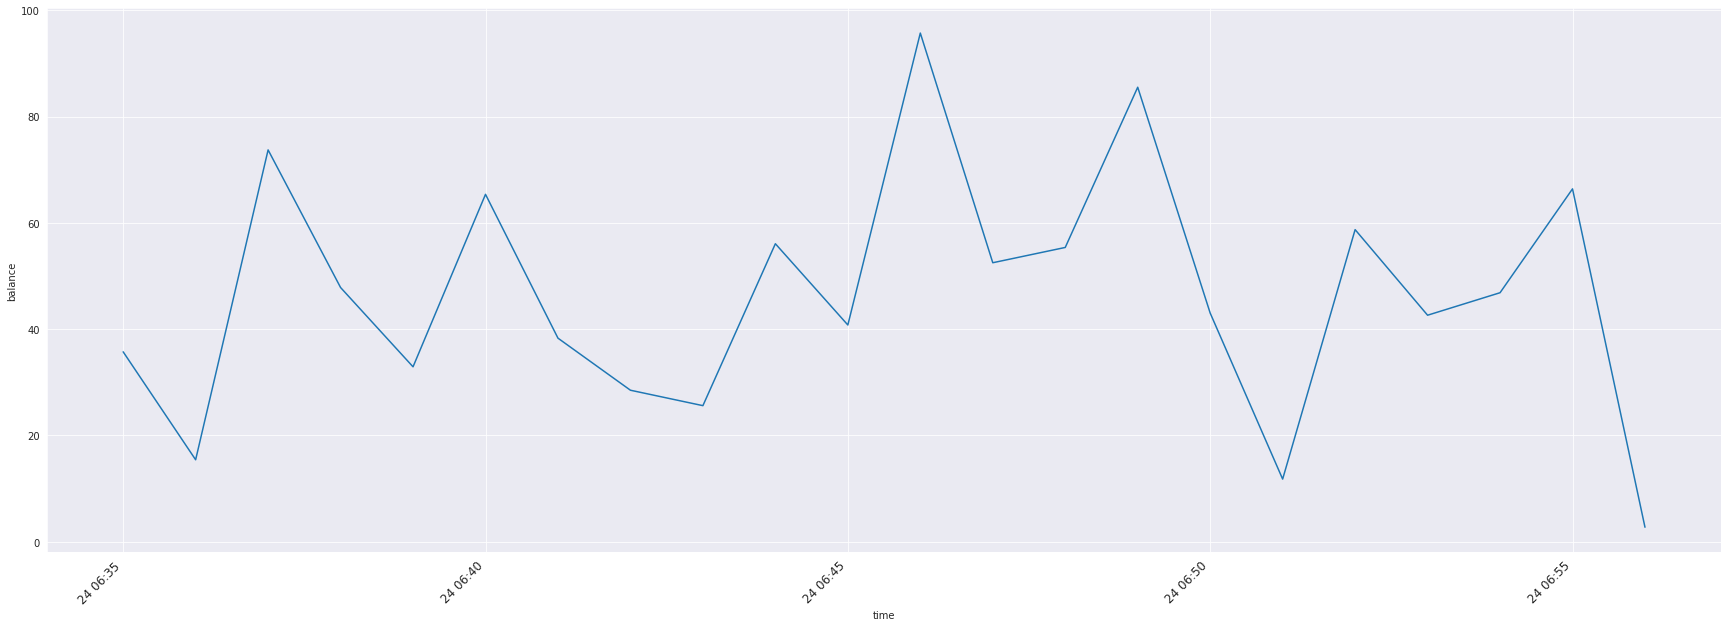

In [23]:
# draw figure
clear_output(wait=True)
plt.figure(figsize=(30,10))
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
sns.set_style("darkgrid")
sns.lineplot(x='time', y='balance', data=df)